# Group interactions 


## Introduction
In this tutorial, we will explore the interaction between any number of junctions. 
We will limit ourselves to the interaction between two junctions, but the code can be easily extended to more junctions.

We will use the `GroupInteraction` class to simulate the interaction between the junctions.
It allows us to define the interaction between the junctions based on the distance between the junctions. 

For documentation, see the [API reference](https://lemurpwned.github.io/cmtj/latest/api/reservoir.html#cmtj.reservoir.GroupInteraction).

## Interaction functions
There are three available interaction functions:

1. `nullDipoleInteraction`: This is the default interaction function. It does not take into account the interaction between the junctions.
2. `computeDipoleInteraction`: Simulates dipole interactions, see [1] for more details.
3. `computeDipoleInteractionNoumra`: Similar to 2., also dipole interactions, see [2] for more details.

[1] Kanao et al., *Reservoir Computing on Spin-Torque Oscillator Array* (2019), https://link.aps.org/doi/10.1103/PhysRevApplied.12.024052   

[2] Nomura et al., *Reservoir computing with dipole-coupled nanomagnets* (2019), https://iopscience.iop.org/article/10.7567/1347-4065/ab2406 



## Experiment 

The experiment we will simulate is a two-junction system with a current flowing only through the first junction.
What we want to see is some oscillation in the second junction that is induced by the current flowing through the first junction and the interaction between the junctions.

The coordinate matrix is defined as a list of position vectors, where each position vector represents the position of a junction with respect to (0, 0, 0) origin.

/opt/homebrew/Caskroom/miniforge/base/envs/.cmtj/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


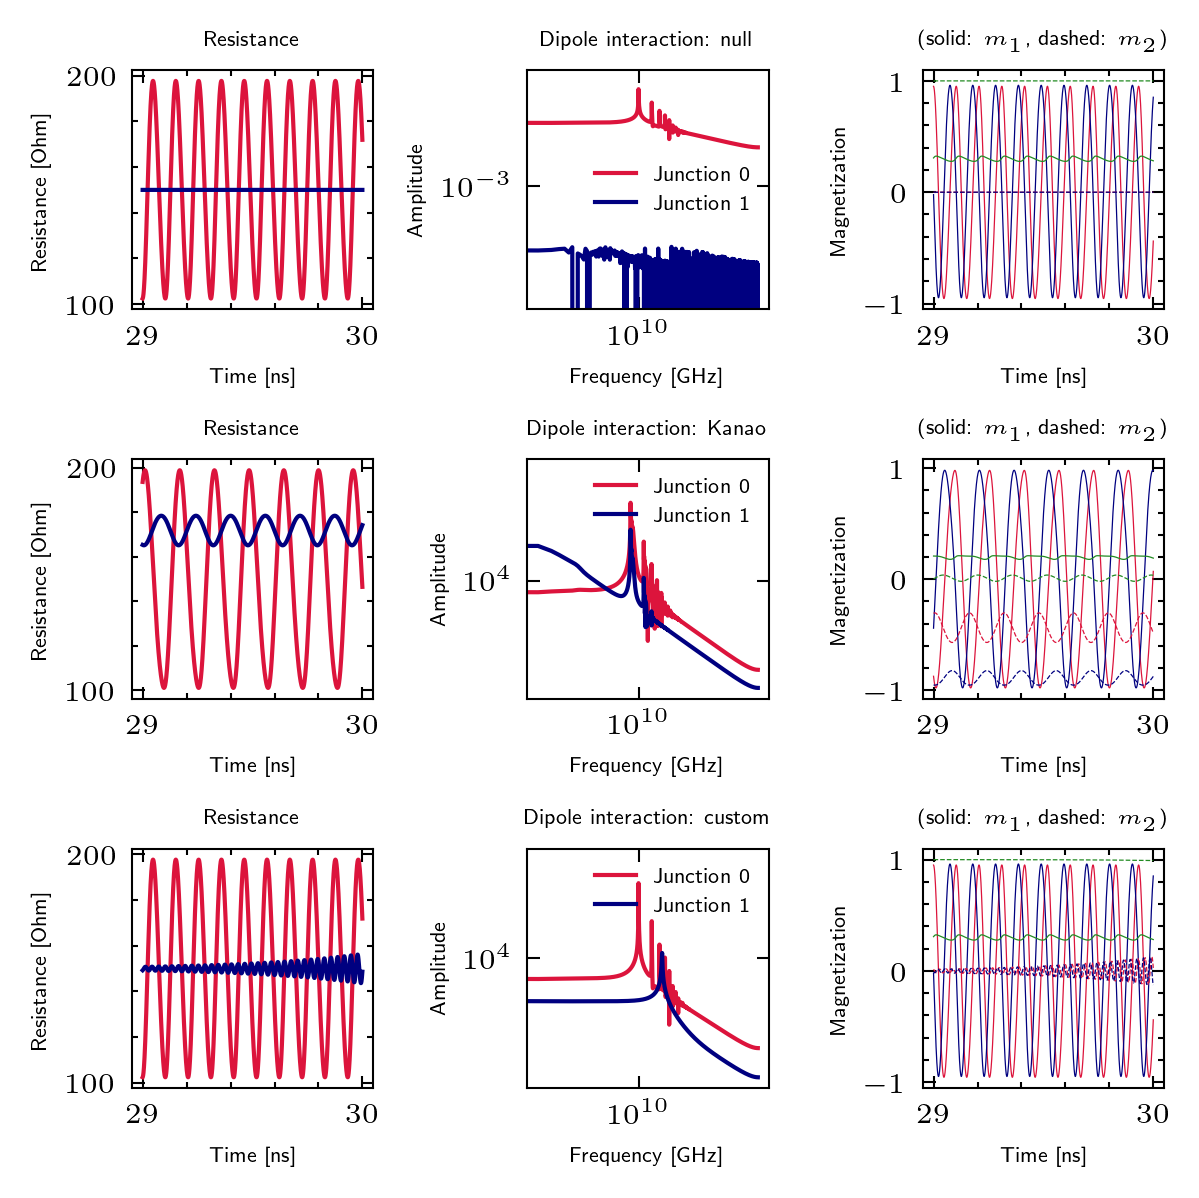

In [1]:
from cmtj.reservoir import (
    GroupInteraction,
    nullDipoleInteraction,
    computeDipoleInteraction,
)

from cmtj import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fftfreq, fft


import matplotlib.pyplot as plt

BETA = 0.1

fontsize = 5

def create_junction(Ms, Ku):
    damping = 1e-2
    surface = np.pi * 50e-9 * 50e-9
    thickness = 3e-9
    spinPolarisation = 0.54
    SLP = spinPolarisation**2
    spinPolarisation = 1
    demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]
    # generate a random start position for the magnetization
    start_m = CVector(
        np.random.uniform(-1, 1), np.random.uniform(-1, 1), np.random.uniform(-1, 1)
    )
    start_m.normalize()
    start_m = CVector(0, 0, 1)
    layer = Layer.createSTTLayer(
        "free",
        start_m,
        CVector(1.0, 0.0, 0.0),
        Ms,
        thickness,
        surface,
        demag,
        damping,
        SLP,
        BETA,
        spinPolarisation,
    )
    layer.setReferenceLayer(CVector(1, 0.0, 0))
    layer.setAnisotropyDriver(constantDriver(Ku))
    return Junction(
        [layer],
        100,
        200,
    )


int_time = 1e-13
Ms = 1.2
Ku = 1e2
m1 = create_junction(Ms, Ku)
m2 = create_junction(
    Ms, Ku * (1 + 0.5)
)  # we slightly modify the anisotropy of the second junction, so they are not identical
jdc = constantDriver(-7e11)
m1.setLayerCurrentDriver("free", jdc)
m1.setLayerExternalFieldDriver("all", AxialDriver(0, 0, 10e3))
m2.setLayerExternalFieldDriver("all", AxialDriver(0, 0, 10e3))
coordinate_matrix = [
    CVector(0, 0, 0),
    CVector(
        200e-9, 0, 0
    ),  # we place the second junction 200 nm away from the first junction in the x direction
]


def customDipoleInteraction(
    r1: CVector, r2: CVector, layer1: Layer, layer2: Layer
) -> CVector:
    dist: CVector = np.power((r1 - r2).length(), 3) * (layer2.Ms / layer1.Ms) * 0.01
    return CVector(dist, 0, 0)


colors = ["crimson", "navy"]
linestyles = ["-", "--"]
fstrs = ["null", "Kanao", "custom"]
lcolors = ["crimson", "navy", "forestgreen"]
fns = [nullDipoleInteraction, computeDipoleInteraction, customDipoleInteraction]
with plt.style.context(["science", "nature"]):
    w, h = plt.figaspect(len(fns) / 3)
    fig, axs = plt.subplots(len(fns), 3, dpi=300, figsize=(w, h))
    for fi, (fn, fstr) in enumerate(zip(fns, fstrs)):
        gi = GroupInteraction(coordinate_matrix, [m1, m2])

        gi.setInteractionFunction(fn)
        gi.runSimulation(30e-9, int_time, int_time)
        c_is = []
        plot_time = 1
        tm_wait = 10
        for i in range(len(coordinate_matrix)):
            log = gi.getLog(i)
            tm = np.asarray(log["time"]) * 1e9
            R = np.asarray(log["R"])
            des_tm = tm.max() - plot_time
            N = np.argwhere(tm > des_tm).ravel().min()
            axs[fi, 0].plot(tm[N:], R[N:], label=f"Junction {i}", color=colors[i])
            # compute fft of R

            idx = np.argwhere(tm > tm_wait).ravel()
            # print(idx)
            R = R[idx]
            fft_R = fft(R)
            freq = fftfreq(len(R), int_time)
            fft_R = np.abs(fft_R)
            fft_R = fft_R[: len(fft_R) // 2]
            freq = freq[: len(freq) // 2]
            axs[fi, 1].plot(freq, fft_R, label=f"Junction {i}", color=colors[i])
            for kl, l in enumerate("xyz"):
                m_l = np.asarray(log[f"free_m{l}"])
                axs[fi, 2].plot(
                    tm[N:],
                    m_l[N:],
                    label=f"Junction {i} {l}",
                    color=lcolors[kl],
                    linestyle=linestyles[i],
                    linewidth=0.3,
                )
        axs[fi, 0].set_xlabel("Time [ns]", fontsize=fontsize)
        axs[fi, -1].set_xlabel("Time [ns]", fontsize=fontsize)
        axs[fi, 0].set_ylabel("Resistance [Ohm]", fontsize=fontsize)
        axs[fi, 1].legend(fontsize=fontsize)
        axs[fi, 1].set_xlabel("Frequency [GHz]", fontsize=fontsize)
        axs[fi, 1].set_ylabel("Amplitude", fontsize=fontsize)
        axs[fi, 2].set_ylabel("Magnetization", fontsize=fontsize)
        axs[fi, 1].set_xscale("log")
        axs[fi, 1].set_yscale("log")

        axs[fi, 0].set_title("Resistance", fontsize=fontsize)
        axs[fi, 1].set_title(f"Dipole interaction: {fstr}", fontsize=fontsize)
        axs[fi, 2].set_title("(solid: $m_1$, dashed: $m_2$)", fontsize=fontsize)
        fig.subplots_adjust(hspace=0.85)
        fig.tight_layout()

### Conclusions

In the first row, we see null dipole interaction (no dipole interaction), and as expected, the resistance is of the second junction is constant.

In the second row, we see the dipole interaction computed by Kanao et al. (2019), and we see that the resistance of the second junction oscillates, even though the current is only flowing through the first junction.

For the third row, we defined a simple function that computes the interaction based on the distance between the junctions:
```python
def customDipoleInteraction(
    r1: CVector, r2: CVector, layer1: Layer, layer2: Layer
) -> CVector:
    dist: CVector = np.power((r1 - r2).length(), 3) * (layer2.Ms / layer1.Ms) * 0.01
    return CVector(dist, 0, 0)
```
The interaction definition is quite simple, and flexible.

We just need to remember that interaction should return a CVector, and that the interaction is defined for each pair of junctions.
In this case, the interaction is asymmetric because:

1. We have the 3rd power of the distance in the formula.
2. We have a scalar factor that depends on whether we are computing the impact of the first junction on the second or the second on the first, (layer1.Ms / layer2.Ms) will differ depending on that.